In [1]:
import pandas as pd
import pipeline as pl
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import math
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

Write functions for model training:

In [2]:
def estimate_weights_using_svd(v, s, u_t, y, sing_vals_to_keep=None,
                               lamb=None, model='trunc_svd_ls'):
    '''
    Estimate weights for regression model using the SVD
    
    Inputs:
        v, s, u: V, Sigma, and U transpose matrices found via
            the SVD on X
        y: vector of labels for X
        sing_vals_to_keep: first n singular values to keep non-zero
        lamb: ridge regularization parameter
        model: which model to estimated; options include 'trunc_svd_ls',
            'svd_ls', and 'ridge'
    '''
    if model == 'ridge':
        I = np.identity(s.shape[0])
        return v @ la.inv((s.T @ s) + (lamb * I)) @ s.T @ u_t @ y
    elif model == 'trunc_svd_ls':
        s_trunc = np.copy(s)
        s_trunc[:, sing_vals_to_keep:] = 0
        s_inv = la.pinv(s_trunc)
        return v @ s_inv @ u_t @ y
    else:
        s_inv = la.pinv(s)
        return v @ s_inv @ u_t @ y

In [3]:
def root_mean_squared_error(true_y, predicted_y):
    '''
    Calculated root mean-squared error
    '''
    return math.sqrt(np.sum((true_y - predicted_y)**2) / len(true_y))

- Read in pickle,
- Create train/test split,
- Normalize 'num_children' column, and
- Split train and test into feature and target dfs

In [4]:
chi_311 = pd.read_pickle("../pickle_files/chi_311.pkl")
chi_311['time_to_close_hr'] = chi_311['time_to_close_sec'] / 3600
chi_311 = chi_311.set_index('SR_NUMBER')
chi_311 = chi_311[chi_311['STATUS'] == 'Completed']
chi_311 = chi_311.drop(columns=['STATUS', 'CREATED_DATE', 'CLOSED_DATE', 'time_to_close_sec'])
chi_311['NUM_CHILDREN'] = chi_311['NUM_CHILDREN'].fillna(0)

In [5]:
train_311, test_311 = pl.create_train_test_split(chi_311)

In [6]:
cols_to_normalize = ['NUM_CHILDREN']
train_311_norm, scaler = pl.normalize(train_311, cols_to_normalize)
test_311_norm, scaler = pl.normalize(test_311, cols_to_normalize, scaler)

In [7]:
train_311_norm, val_311_norm = pl.create_train_test_split(train_311_norm)

In [8]:
train_feat = train_311_norm.iloc[:, :-1]
features = list(train_feat.columns)
train_feat = np.array(train_feat, dtype=np.float)
train_targ = np.array(pd.DataFrame(train_311_norm.iloc[:, -1]), dtype=np.float)
test_feat = np.array(test_311_norm.iloc[:, :-1], dtype=np.float)
test_targ = np.array(pd.DataFrame(test_311_norm.iloc[:, -1]), dtype=np.float)
val_feat = np.array(val_311_norm.iloc[:, :-1], dtype=np.float)
val_targ = np.array(pd.DataFrame(val_311_norm.iloc[:, -1]), dtype=np.float)

**SVD / Principal Components**

**Note - mention we performed economy SVD, but it didn't change anything (full rank); however, it is close to being low rank (has some low singular values - see 3rd projection)**

In [9]:
u, s, v_t = la.svd(train_feat, full_matrices=False)

**Include both plots in paper - include hypotheses (sparse matrix, etc.)**

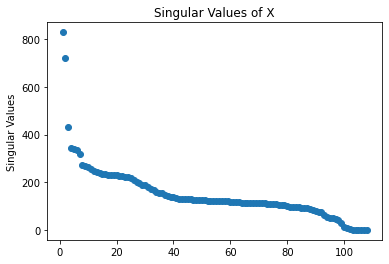

In [10]:
x_const = np.arange(1, 109)
ax1 = plt.subplot()
plt.scatter(x_const, s)
ax1.set_title('Singular Values of X')
ax1.set_ylabel('Singular Values')
plt.show()

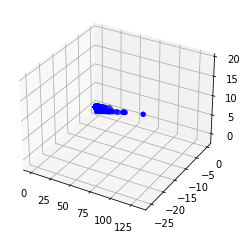

In [11]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

pcs = train_feat @ v_t.T
p = ax.scatter(pcs[:, 0], pcs[:, 1], pcs[:, 2], c='b')

Grid search - number of principal components for PCR

*note - using holdout validation set instead of cross validation b/c dataset is large, cross-validation is infeasible given our computational resources*

In [12]:
num_sing_vals = [1, 2, 5, 10, 50, 75, 100, 108]
results_trunc = np.zeros((len(num_sing_vals), 2))

for i, sing_val in enumerate(num_sing_vals):
    results_trunc[i, 0] = sing_val
    weights = estimate_weights_using_svd(v_t.T, np.diag(s), u.T, train_targ,
                                         sing_vals_to_keep=sing_val,
                                         model='trunc_svd_ls')
    results_trunc[i, 1] = root_mean_squared_error(val_targ, val_feat @ weights)
    
results_trunc_df = pd.DataFrame(data = results_trunc,  
                          columns = ['Num Singular Values', 'RMSE'])

In [13]:
lambdas = [0, 1, 5, 10, 100, 100000]
results_ridge = np.zeros((len(lambdas), 2))

for i, lamb in enumerate(lambdas):
    results_ridge[i, 0] = lamb
    weights = estimate_weights_using_svd(v_t.T, np.diag(s), u.T, train_targ,
                                         lamb=lamb, model='ridge')
    results_ridge[i, 1] = root_mean_squared_error(val_targ, val_feat @ weights)
    
results_ridge_df = pd.DataFrame(data = results_ridge,  
                                columns = ['Lambda', 'RMSE'])

In [14]:
results_trunc_df

,Num Singular Values,RMSE
0,1.0,1799.043072
1,2.0,1672.758274
2,5.0,1614.586846
3,10.0,1611.456997
4,50.0,1583.104402
5,75.0,1580.912876
6,100.0,1576.090408
7,108.0,1575.853000


In [15]:
results_ridge_df

,Lambda,RMSE
0,0.0,1576.093317
1,1.0,1575.848757
2,5.0,1575.852535
3,10.0,1575.858287
4,100.0,1575.958189
5,100000.0,1609.232519


**NEXT: Plot both RMSE; do classification on whether request fulfilled in one week (which is about the median)**

In [16]:
train_targ_week = np.where(train_targ <= 168.0, 1, -1)
test_targ_week = np.where(test_targ <= 168.0, 1, -1)
val_targ_week = np.where(val_targ <= 168.0, 1, -1)

In [17]:
def classification_err(y_true, y_hat):
    y_hat = np.sign(y_hat)
    test_matches = np.equal(y_hat, y_true)
    return (y_hat.size - np.sum(test_matches))/y_hat.size

In [18]:
lambdas = [0, 1, 5, 10, 100, 100000]
results_ridge_cls = np.zeros((len(lambdas), 2))

for i, lamb in enumerate(lambdas):
    results_ridge_cls[i, 0] = lamb
    weights = estimate_weights_using_svd(v_t.T, np.diag(s), u.T, train_targ_week,
                                         lamb=lamb, model='ridge')
    results_ridge_cls[i, 1] = classification_err(val_targ_week, val_feat @ weights)
    
results_ridge_cls = pd.DataFrame(data = results_ridge_cls,  
                                columns = ['Lambda', 'Classification Error'])

In [19]:
num_sing_vals = [1, 2, 5, 10, 50, 75, 100, 108]
results_trunc_cls = np.zeros((len(num_sing_vals), 2))

for i, sing_val in enumerate(num_sing_vals):
    results_trunc_cls[i, 0] = sing_val
    weights = estimate_weights_using_svd(v_t.T, np.diag(s), u.T, train_targ_week,
                                         sing_vals_to_keep=sing_val, model='trunc_svd_ls')
    results_trunc_cls[i, 1] = classification_err(val_targ_week, val_feat @ weights)
    
results_trunc_cls = pd.DataFrame(data = results_trunc_cls,  
                                columns = ['Number of Singular Values', 
                                           'Classification Error'])

In [20]:
results_ridge_cls

,Lambda,Classification Error
0,0.0,0.350931
1,1.0,0.348867
2,5.0,0.348873
3,10.0,0.348915
4,100.0,0.348909
5,100000.0,0.372737


In [21]:
results_trunc_cls

,Number of Singular Values,Classification Error
0,1.0,0.450984
1,2.0,0.453532
2,5.0,0.419556
3,10.0,0.412559
4,50.0,0.361002
5,75.0,0.353539
6,100.0,0.348934
7,108.0,0.348903


### Now let's try the SVM!

In [22]:
train_targ_week.shape

(660928, 1)

In [23]:
print(train_targ_week)

[[ 1]
 [ 1]
 [ 1]
 ...
 [-1]
 [-1]
 [-1]]


In [27]:
print(train_targ_week.reshape(-1))

[ 1  1  1 ... -1 -1 -1]


In [28]:
train_targ_week.reshape(-1).shape

(660928,)

In [ ]:
# try to see if this will run
svc = LinearSVC()
svc.fit(train_feat, train_targ_week.reshape(-1))
print('classification error: ', classification_err(val_targ_week, svc.predict(val_feat)))


In [ ]:
# c_range = np.arange(1, 4)
# results_svc = np.zeros((len(c_range), 2))
# for i, c in enumerate(c_range):
#     results_svc[i, 0] = c
#     svc = LinearSVC(C=c)
#     svc.fit(train_feat, train_targ_week.reshape(-1))
#     results_svc[i, 1] = classification_err(val_targ_week, svc.predict(val_feat))
    
# results_svc = pd.DataFrame(data = results_svc,  
#                                 columns = ['c Parameter', 
#                                            'Classification Error'])



/opt/anaconda3/envs/“project”/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
